In [1]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import matplotlib.pyplot as plt
import shap

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, auc, accuracy_score, roc_auc_score, confusion_matrix, roc_curve
from catboost import CatBoostClassifier
from category_encoders import CatBoostEncoder
from catboost import Pool
from IPython.display import JSON


In [2]:
# Load your data into a pandas dataframe
df = pd.read_csv('D:\LULUS APRIL\Book\DATASETKORELASI.csv')

In [3]:
df=pd.DataFrame(df)

In [4]:
df

,Kewarganegaraan,Jenis Kelamin,Menerima beasiswa,Fakultas,Jurusan,Golongan UKT,Tempat tinggal yang ditempati selama kuliah offline,Pekerjaan Orang Tua,Transportasi yang digunakan sehari-hari,Biaya pengeluaran rutin setiap bulan,...,Frekuensi penggunaan platform layanan pesan antar,Berlangganan platform hiburan berbayar,Biaya pengluaran untuk berlangganan platform hiburan berbayar,Biaya pengeluaran untuk hiburan setiap bulan,Sumber air minum yang anda konsumsi,Sumber bahan bakar yang Anda gunakan saat memasak,Konsumsi Tembakau atau Rokok Elektrik (Pod atau Vape),"Biaya pengeluaran untuk konsumsi Tembakau, Pods, ataupun Vape setiap Bulan",Skor SES,SES
0,WNI,Laki-laki,Ya,Adab dan Humaniora,Ilmu Peustakaan,Golongan 2,Rumah,Lain-lain,Transjakarta,1000000,...,5,Tidak,0,100000,Air minum dalam galon isi ulang,Gas 3 Kg,Tidak,0,11,SES C1
1,WNI,Perempuan,Tidak,Psikologi,Psikologi,Golongan 7,Kost,PNS,Berjalan Kaki,3000000,...,10,Ya,100000,500000,Air minum dalam galon isi ulang,Gas Elpiji – 12 Kg/ Gas 7 Kg/Gas 5 Kg,Tidak,0,15,SES A
2,WNI,Perempuan,Tidak,Adab dan Humaniora,Ilmu Peustakaan,Golongan 5,Rumah,Karyawan Swasta,Motor,2000000,...,5,Ya,100000,250000,Air minum dalam galon isi ulang,Gas 3 Kg,Tidak,0,12,SES C1
3,WNI,Perempuan,Ya,Ilmu Sosial dan Ilmu Politik,Ilmu Hubungan Internasional,Golongan 1,Rumah,Karyawan Swasta,Motor,1500000,...,5,Tidak,0,250000,Air minum dalam kemasan botol/galon bermerek,Gas 3 Kg,Tidak,0,13,SES B
4,WNI,Perempuan,Tidak,Sains dan Teknologi,Fisika,Golongan 7,Rumah,Wiraswasta,Transjakarta,2000000,...,5,Ya,100000,250000,Air minum dalam kemasan botol/galon bermerek,Gas Elpiji – 12 Kg/ Gas 7 Kg/Gas 5 Kg,Tidak,0,15,SES A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,WNI,Perempuan,Tidak,Ekonomi dan Bisnis,Akuntansi,Golongan 5,Rumah,Lain-lain,Motor,1000000,...,5,Tidak,0,150000,Air sumur bor/pompa,Gas 3 Kg,Tidak,0,11,SES C1
396,WNI,Perempuan,Tidak,Psikologi,Psikologi,Golongan 6,Rumah,Wiraswasta,Motor,1500000,...,5,Tidak,0,250000,Air minum dalam galon isi ulang,Gas Elpiji – 12 Kg/ Gas 7 Kg/Gas 5 Kg,Tidak,0,14,SES B
397,WNI,Perempuan,Tidak,Psikologi,Psikologi,Golongan 6,Rumah,Lain-lain,Motor,1000000,...,5,Tidak,0,100000,Air PAM,Gas Elpiji – 12 Kg/ Gas 7 Kg/Gas 5 Kg,Tidak,0,13,SES B
398,WNI,Laki-laki,Tidak,Ekonomi dan Bisnis,Manajemen,Golongan 6,Rumah,Karyawan Swasta,Motor,2000000,...,10,Ya,100000,500000,Air minum dalam kemasan botol/galon bermerek,Gas Elpiji – 12 Kg/ Gas 7 Kg/Gas 5 Kg,Tidak,0,16,SES A


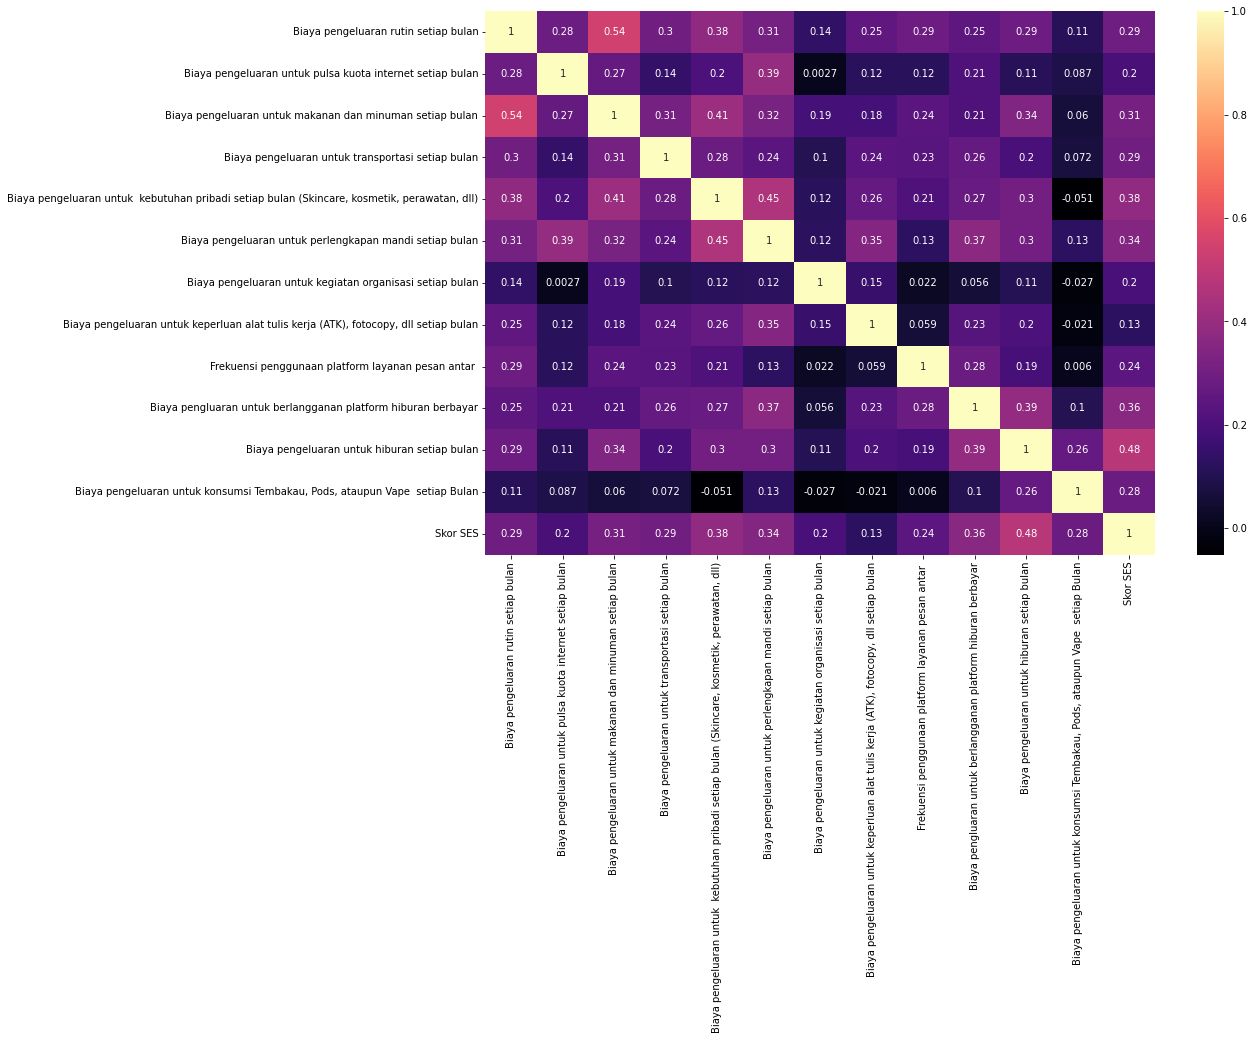

In [5]:
#setting dataset
X = df[['Biaya pengeluaran untuk pulsa kuota internet setiap bulan',
        'Biaya pengeluaran untuk makanan dan minuman setiap bulan',
        'Biaya pengeluaran untuk  kebutuhan pribadi setiap bulan (Skincare, kosmetik, perawatan, dll)',
        'Biaya pengeluaran untuk perlengkapan mandi setiap bulan',
        'Biaya pengeluaran untuk kegiatan organisasi setiap bulan',
        'Biaya pengeluaran untuk keperluan alat tulis kerja (ATK), fotocopy, dll setiap bulan',
        'Biaya pengluaran untuk berlangganan platform hiburan berbayar',
        'Biaya pengeluaran untuk hiburan setiap bulan',
        'Biaya pengeluaran untuk konsumsi Tembakau, Pods, ataupun Vape  setiap Bulan']].values #variabel input
y = df[['SES']].values #varibael target/output

#proses perbandingan matriks korelasi untuk setiap atribut
corrmat = df.corr()
top_corr_features = corrmat.index

#visualisasi dengan heatmap
plt.figure(figsize=(15,10))
sns.heatmap(df[top_corr_features].corr(), annot=True, cmap="magma")
plt.show()

In [6]:
# create training and testing vars
y1=df.SES
df_train, df_test, y_df_train, y_df_test = train_test_split(df, y1, test_size=0.2)
drop_list=['Kewarganegaraan',
           'Jenis Kelamin',
           'Jurusan',
           'Pembayaran operator seluler',
           'E-wallet yang sering digunakan',
           'Platform layanan pesan antar apa yang paling sering digunakan',
           'Platform e-commerce yang paling sering digunakan',
           'Organisasi',
           'Frekuensi penggunaan platform layanan pesan antar ',
           'Berlangganan platform hiburan berbayar',
           'Sumber air minum yang anda konsumsi',
           'Sumber bahan bakar yang Anda gunakan saat memasak',
           'Konsumsi Tembakau atau Rokok Elektrik (Pod atau Vape)','SES', 'Skor SES',
           'Transportasi yang digunakan sehari-hari', 'Tempat tinggal yang ditempati selama kuliah offline', 'Menerima beasiswa']
X=df_train.drop(drop_list,axis=1)
X_test = df_test.drop(drop_list,axis=1)
y = df_train.SES
SEED = 1
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=SEED)
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
cat_features= X_train.select_dtypes(exclude=numerics).columns.tolist()

In [7]:
cat_features

['Fakultas', 'Golongan UKT', 'Pekerjaan Orang Tua']

In [8]:
from catboost import Pool

train_data = Pool(data=X_train,
                  label=y_train,
                  cat_features=cat_features
                 )

valid_data = Pool(data=X_valid,
                  label=y_valid,
                  cat_features=cat_features
                 )

In [9]:
params= {'loss_function':'MultiClass',
         'eval_metric':'AUC',
         'iterations':200,
         'early_stopping_rounds': 200,
         'verbose': 200,
         'random_seed': SEED
        }

In [10]:
# Create a CatBoostClassifier model
cat_model = CatBoostClassifier(**params)

# Fit the model to the training data
cat_model.fit(train_data, # instead of X_train, y_train
              eval_set=valid_data, # instead of (X_valid, y_valid)
              use_best_model=True, 
              plot=True,
             )


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.194312
0:	test: 0.6172075	best: 0.6172075 (0)	total: 174ms	remaining: 34.6s
199:	test: 0.7411859	best: 0.7495192 (188)	total: 8.82s	remaining: 0us

bestTest = 0.7495192308
bestIteration = 188

Shrink model to first 189 iterations.


In [11]:
predictions = cat_model.predict(X_train)

report_dict = {}
report_dict = classification_report(y_train, predictions, output_dict=True)
# print(predictions)
report_dict['accuracy'] = accuracy_score(y_train, predictions)
report_dict['confusion'] = confusion_matrix(y_train, predictions).tolist()
report_dict['model_features'] = X_train.columns.to_list()

importances = cat_model.get_feature_importance()
# std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0).tolist()
indices = np.argsort(importances)[::-1]
report_dict['feature_importance'] = {X_train.columns[idx]: float(importances[idx]) for idx in indices}

from IPython.display import JSON
JSON(report_dict)

report_dict

{'SES A': {'precision': 0.9642857142857143,
  'recall': 0.8307692307692308,
  'f1-score': 0.8925619834710744,
  'support': 65},
 'SES B': {'precision': 0.8205128205128205,
  'recall': 0.9411764705882353,
  'f1-score': 0.8767123287671232,
  'support': 102},
 'SES C1': {'precision': 0.8375,
  'recall': 0.8170731707317073,
  'f1-score': 0.8271604938271605,
  'support': 82},
 'SES C2': {'precision': 1.0,
  'recall': 0.42857142857142855,
  'f1-score': 0.6,
  'support': 7},
 'accuracy': 0.859375,
 'macro avg': {'precision': 0.9055746336996336,
  'recall': 0.7543975751651504,
  'f1-score': 0.7991087015163396,
  'support': 256},
 'weighted avg': {'precision': 0.8673667153159341,
  'recall': 0.859375,
  'f1-score': 0.8572982302878654,
  'support': 256},
 'confusion': [[54, 6, 5, 0], [1, 96, 5, 0], [1, 14, 67, 0], [0, 1, 3, 3]],
 'model_features': ['Fakultas',
  'Golongan UKT',
  'Pekerjaan Orang Tua',
  'Biaya pengeluaran rutin setiap bulan',
  'Biaya pengeluaran untuk pulsa kuota internet seti

In [12]:
x =cat_model.get_feature_importance(prettified=True)
print(x.head(100))

                                           Feature Id  Importances
0                                        Golongan UKT    21.556482
1                                 Pekerjaan Orang Tua    17.143114
2                                            Fakultas    11.364814
3        Biaya pengeluaran untuk hiburan setiap bulan    10.619466
4                Biaya pengeluaran rutin setiap bulan     6.045604
5   Biaya pengeluaran untuk transportasi setiap bulan     5.270478
6   Biaya pengeluaran untuk  kebutuhan pribadi set...     4.798922
7   Biaya pengluaran untuk berlangganan platform h...     4.712372
8   Biaya pengeluaran untuk perlengkapan mandi set...     4.068001
9   Biaya pengeluaran untuk kegiatan organisasi se...     3.724892
10  Biaya pengeluaran untuk makanan dan minuman se...     3.390958
11  Biaya pengeluaran untuk keperluan alat tulis k...     3.366039
12  Biaya pengeluaran untuk pulsa kuota internet s...     2.609705
13  Biaya pengeluaran untuk konsumsi Tembakau, Pod...     1.32

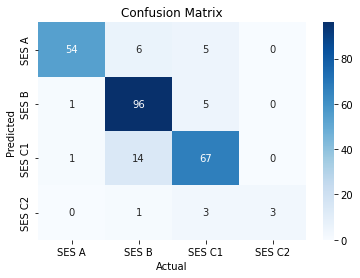

In [13]:
predictions = cat_model.predict(X_train)
cm = confusion_matrix(y_train, predictions)

sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')

plt.xlabel('Actual')
plt.ylabel('Predicted ')
plt.title('Confusion Matrix')
plt.xticks([0.5, 1.5, 2.5, 3.5], ['SES A', 'SES B', 'SES C1', 'SES C2'])
plt.yticks([0.5, 1.5, 2.5, 3.5],['SES A', 'SES B', 'SES C1', 'SES C2'])
plt.show()

In [14]:
# Compute the probabilities for each class
probas = cat_model.predict_proba(X_train)

# Initialize the ROC curve dictionary
roc_dict = {}

# Loop through each class
for i in range(len(cat_model.classes_)):
    # Extract the probability scores for the current class
    y_prob = probas[:, i]
    
    # Create a binary target variable for the current class
    y_true = (y_train == cat_model.classes_[i]).astype(int)
    
    # Compute the ROC curve and AUC score for the current class
    fpr, tpr, threshold = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    
    # Add the ROC curve and AUC score to the dictionary
    roc_dict[f'class_{i}'] = {'fpr': fpr.tolist(), 'tpr': tpr.tolist(), 'threshold': threshold.tolist(), 'roc_auc': roc_auc}
    
# Add the ROC curve dictionary to the report dictionary
report_dict['roc_curve'] = roc_dict


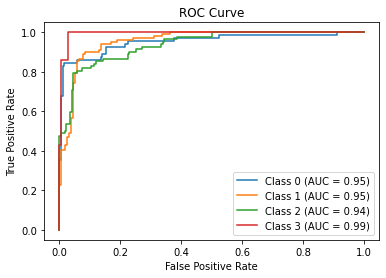

In [15]:
# Loop through each class and plot the ROC curve
for i in range(len(cat_model.classes_)):
    # Get the fpr, tpr, and threshold values for the current class
    fpr = roc_dict[f'class_{i}']['fpr']
    tpr = roc_dict[f'class_{i}']['tpr']
    threshold = roc_dict[f'class_{i}']['threshold']
    
    # Plot the ROC curve
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_dict[f"class_{i}"]["roc_auc"]:.2f})')
    
# Add labels and title to the plot
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

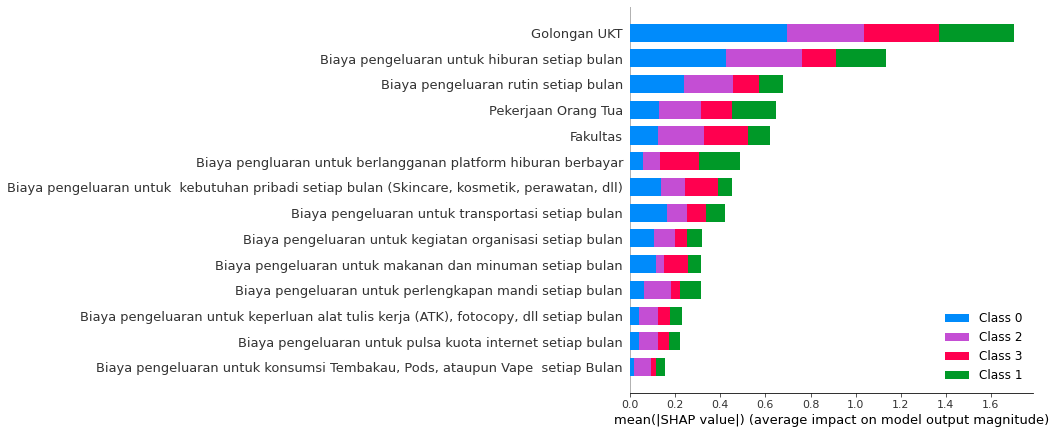

In [17]:
explainer = shap.TreeExplainer(cat_model) # insert your model
shap_values = explainer.shap_values(train_data) # insert your train Pool object

shap.initjs()
fig, ax = plt.subplots(figsize=(10,6))
shap.summary_plot(shap_values, X_train, plot_type="bar", show=False)
plt.subplots_adjust(left=0.2)  # adjust the left margin to make room for the y-axis label
plt.show()